In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from tqdm import tqdm
from plotnine import *

from unified_model import MechanicalModel
from unified_model import ElectricalModel
from unified_model import mechanical_components
from unified_model import electrical_components
from unified_model import CouplingModel
from unified_model import governing_equations
from unified_model import gridsearch  # <-- The new set of tools we'll be using exist in the `gridsearch` module
from unified_model import optimize

from flux_modeller.model import CurveModel

In [4]:
# Mechanical components
magnetic_spring = mechanical_components.MagneticSpringInterp(
    fea_data_file='../data/magnetic-spring/10x10alt.csv',
    magnet_length=10/1000,
    filter_callable=lambda x: savgol_filter(x, window_length=27, polyorder=5)
)

mech_spring = mechanical_components.MechanicalSpring(
    position=110/1000,
    damping_coefficient=7.778,
    magnet_length=10/1000
)
damper = mechanical_components.ConstantDamper(0.0433)

# Electrical Components
R_coil = None  # Need to get from `optimize` module
load = electrical_components.SimpleLoad(R=30)
v_rect_drop = 0.1
coupling_model = CouplingModel().set_coupling_constant(4.444)

coil_model_params = {
    'c': 1,
    'n_z': 200,
    'n_w': 200,
    'l_ccd_mm': 10,
    'ohm_per_mm': 1361/1000/1000,
    'tube_wall_thickness_mm': 2,
    'coil_wire_radius_mm': 0.143/2,
    'coil_center_mm': 59,
    'outer_tube_radius_mm': 5.5
}

magnet_assembly_params = {
    'm': 1,
    'l_m_mm': 10,
    'l_mcd_mm': 100,
    'dia_magnet_mm': 10,
    'dia_spacer_mm': 10
}

curve_model = CurveModel.load('../data/flux_curve_model/flux_curve_model_2021_05_11.model')

# Build our first "template" factory
unified_model_factory = gridsearch.UnifiedModelFactory(
    damper=damper,
    magnet_assembly=None,
    mechanical_spring=mech_spring,
    magnetic_spring=magnetic_spring,
    coil_model=None,
    rectification_drop=v_rect_drop,
    load_model=load,
    flux_model=None,
    dflux_model=None,
    coupling_model=coupling_model,
    governing_equations=governing_equations.unified_ode,
    model_id=0,
)

# Choose our input excitations, in the case just one (for now)
from glob import glob
acc_inputs = []
for log_file in glob('../data/2019-05-23_D/A/log*_acc.csv'):
    acc_input = mechanical_components.AccelerometerInput(
        raw_accelerometer_input=log_file,
        accel_column='z_G',
        time_column='time(ms)',
        accel_unit='g',
        time_unit='ms',
        smooth=True,
        interpolate=True
    )
    acc_inputs.append(acc_input)

# Try evolve it

simulation_models = optimize.evolve_simulation_set(unified_model_factory=unified_model_factory,
                                                  input_excitations=acc_inputs,
                                                  curve_model=curve_model,
                                                  coil_model_params=coil_model_params,
                                                  magnet_assembly_params=magnet_assembly_params)

print(len(simulation_models))

TypeError: __init__() got an unexpected keyword argument 'magnet_length'

In [81]:
um = simulation_models[0]

In [84]:
z_arr = np.linspace(-0.1, 0.2, 1000)
phi = um.electrical_model.flux_model.get(z_arr)

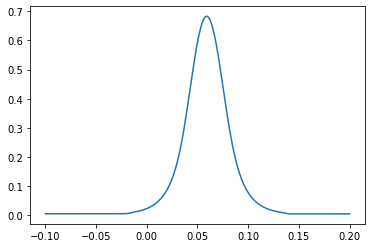

In [85]:
import matplotlib.pyplot as plt
plt.plot(z_arr, phi)

In [8]:
CurveModel.load?

Signature: CurveModel.load(path: str) -> Any
Docstring: <no docstring>
File:      ~/Nextcloud/nextcloud/PhD/Python/flux_modeller/flux_modeller/model.py
Type:      function


In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
from unified_model.electrical_components.flux.model import FluxModelInterp
from unified_model import electrical_components
from unified_model import mechanical_components
from unified_model import optimize
import matplotlib.pyplot as plt
from itertools import product
from copy import copy
from flux_modeller.model import CurveModel
import numpy as np

import ray
ray.init(num_cpus=12, ignore_reinit_error=True)
n_z_arr = np.arange(0, 201, 2)
n_w_arr = np.arange(0, 201, 2)

curve_model = CurveModel.load('../data/flux_curve_model/flux_curve_model_2021_05_11.model')
coil_params = {
    'c': 1,
    'n_z': 100,  # These don't matter, just can't be `None`
    'n_w': 100,  # These don't matter, just can't be `None`
    'l_ccd_mm': 10,
    'ohm_per_mm': 1361/1000/1000,
    'tube_wall_thickness_mm': 2,
    'coil_wire_radius_mm': 0.143/2,
    'coil_center_mm': 59,
    'inner_tube_radius_mm': 5.5
}

coil_config = electrical_components.coil.CoilConfiguration(**coil_params)

magnet_assembly = mechanical_components.MagnetAssembly(
    m=1,
    l_m_mm=10,
    l_mcd_mm=0,
    dia_magnet_mm=10,
    dia_spacer_mm=10
)

optimize.precompute_best_spacing(n_z_arr, n_w_arr, curve_model, coil_config, magnet_assembly, 'optimal_l_ccd_0_200_5_v2.csv')

2021-05-13 15:22:20,616	INFO worker.py:651 -- Calling ray.init() again after it has already been called.
100%|██████████| 10201/10201 [1:09:46<00:00,  2.44it/s]


In [32]:
import pandas as pd

df = pd.read_csv('optimal_l_ccd_0_200_5_v2.csv')

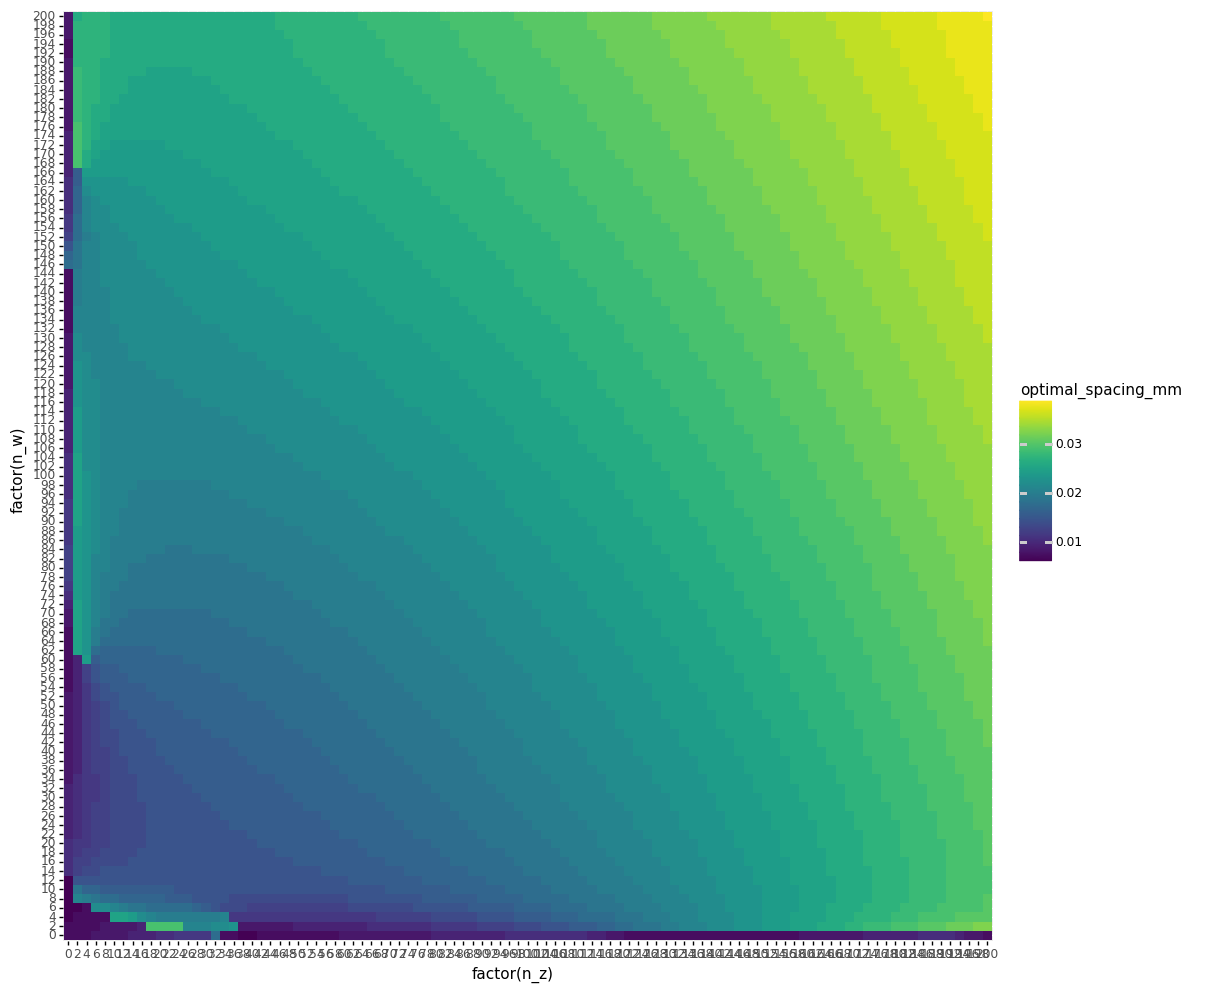

<ggplot: (8769346832741)>

In [36]:
from plotnine import *

p = qplot(x='factor(n_z)', y='factor(n_w)', fill='optimal_spacing_mm', geom='tile', data=df)
p + coord_equal() + theme(figure_size=(12, 12))

In [37]:
df_base = pd.read_csv('../data/flux_curve_model/optimal_l_ccd_0_200_2.csv')
df_base.head()

,Unnamed: 0,n_z,n_w,optimal_spacing_mm
0,0,0,0,0.008001
1,1,0,2,0.008001
2,2,0,4,0.021001
3,3,0,6,0.020001
4,4,0,8,0.019001


In [38]:
df_base.query('n_z == 80 and n_w == 20')

,Unnamed: 0,n_z,n_w,optimal_spacing_mm
4050,4050,80,20,0.024001


In [39]:
df.query('n_z == 80 and n_w == 20')

,Unnamed: 0,n_z,n_w,optimal_spacing_mm
4050,4050,80,20,0.018001


In [16]:
for xx, yy in x:
    xx

In [53]:
def batchify(x, batch_size):
    total_size = len(x)
    indexes = np.arange(0, total_size, batch_size)
    
    if indexes[-1] < total_size:
        indexes = np.append(indexes, [total_size])
        
    return [x[indexes[i]:indexes[i+1]] for i in range(len(indexes)-1)]

In [34]:
df_1c1m = pq.read_table('1c1m_test_optimization.parquet').to_pandas()
df_2c1m = pq.read_table('2c1m_test_optimization.parquet').to_pandas()
df_1c1m.head()

,n_z,n_w,p_load_avg
0,2,2,0.000000e+00
1,2,4,0.000000e+00
2,2,6,0.000000e+00
3,2,8,4.485553e-11
4,2,10,1.190906e-08


In [35]:
df_1c1m.sort_values(by='p_load_avg', ascending=False).head(10)

,n_z,n_w,p_load_avg
1536,94,18,0.000262
1337,90,20,0.000262
1237,88,20,0.000262
1437,92,20,0.000262
1436,92,18,0.000262
1137,86,20,0.000261
1336,90,18,0.000261
1037,84,20,0.000261
1537,94,20,0.000261
1637,96,20,0.000261


In [36]:
df_2c1m.sort_values(by='p_load_avg', ascending=False).head(10)

,n_z,n_w,p_load_avg
6878,78,14,0.000195
6978,80,14,0.000195
6579,72,16,0.000194
6679,74,16,0.000194
6779,76,16,0.000194
6479,70,16,0.000193
6778,76,14,0.000193
6578,72,14,0.000193
6678,74,14,0.000193
9,84,12,0.000193


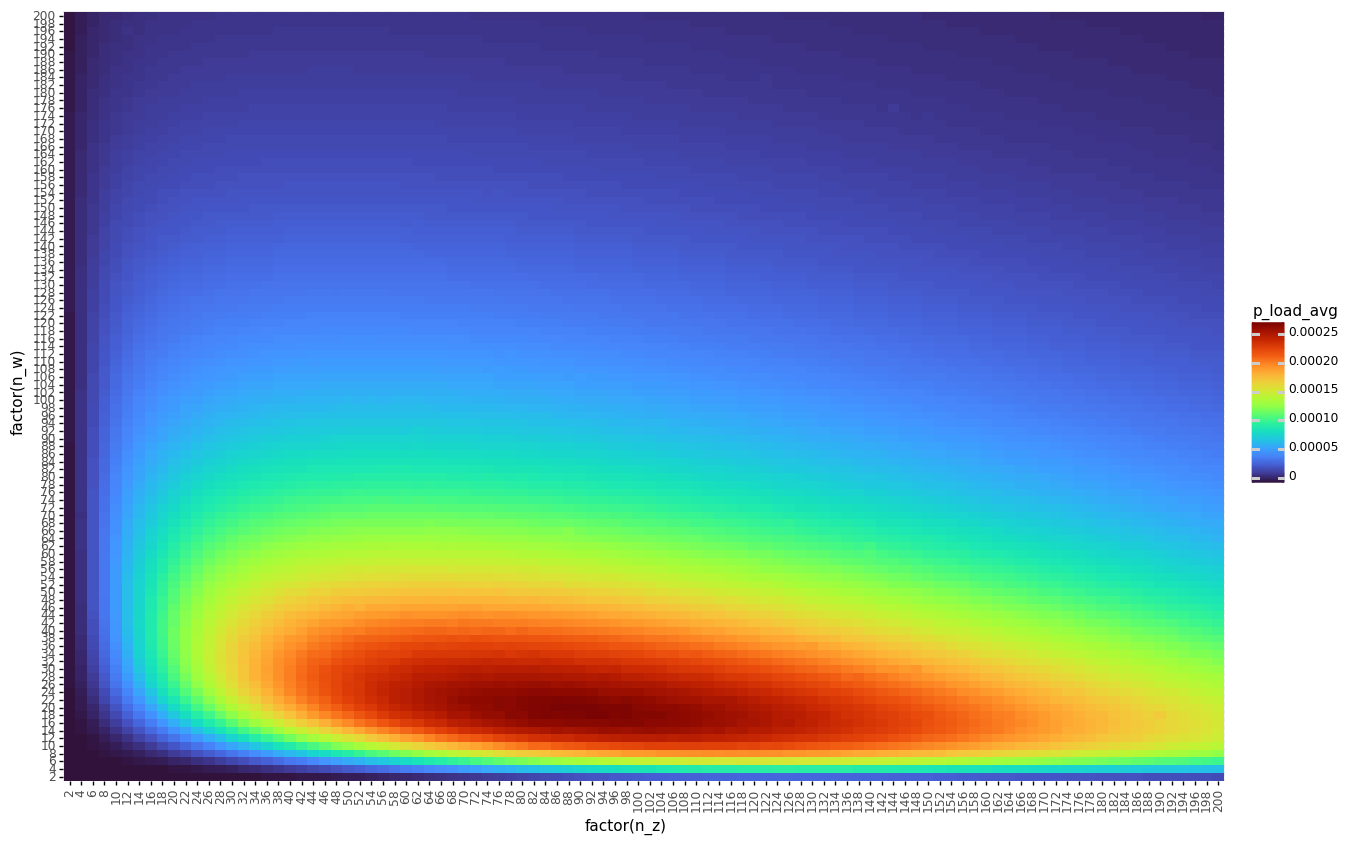

<ggplot: (8748129189481)>

In [37]:
p = ggplot(aes(x='factor(n_z)', y='factor(n_w)', fill='p_load_avg'), df_1c1m)
p + geom_tile() + scale_fill_cmap('turbo') + theme(figure_size=(15, 10), axis_text_x=element_text(angle=90))

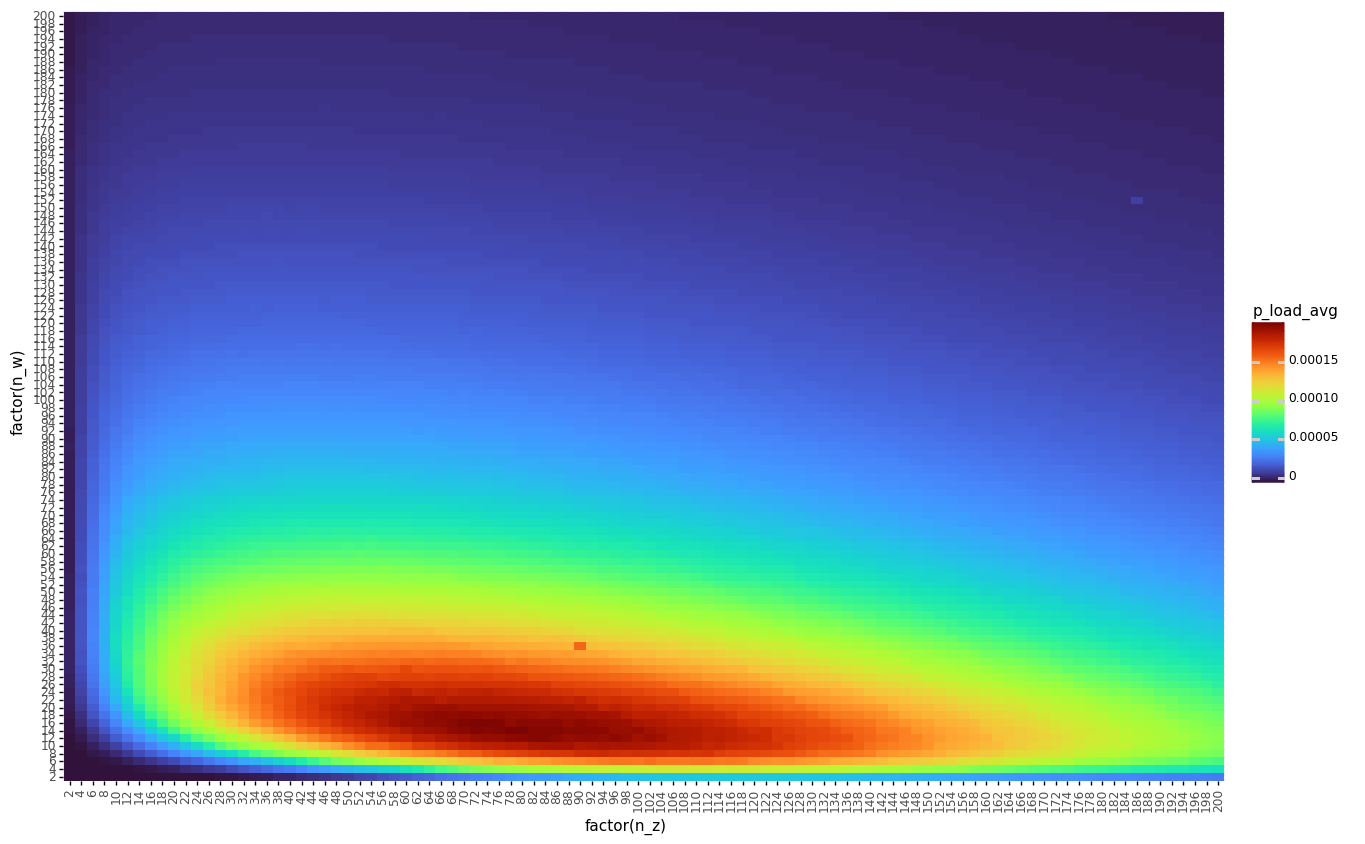

<ggplot: (8748127907925)>

In [38]:
p = ggplot(aes(x='factor(n_z)', y='factor(n_w)', fill='p_load_avg'), df_2c1m)
p + geom_tile() + scale_fill_cmap('turbo') + theme(figure_size=(15, 10), axis_text_x=element_text(angle=90))

# Constant velocity debugging

In [5]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
from itertools import product

In [29]:
from copy import copy

def update_coil_params(coil_params, n_z, n_w, c, m):
    coil_params = copy(coil_params)
    coil_params['n_z'] = n_z
    coil_params['n_w'] = n_w
    coil_params['c'] = c
    coil_params['m'] = m
    
    if c > 1:
        coil_params['l_ccd'] = optimize.lookup_best_spacing('optimal_l_ccd_0_200_5.csv', n_z, n_w)
    else:
        coil_params['l_ccd'] = 0
    return coil_params

def get_emf(n_z, n_w, c, coil_params):
    coil_params = update_coil_params(coil_params, n_z, n_w, c)
    z_arr = np.linspace(0, 0.2, 1000)
    flux, dflux = optimize.get_new_flux_and_dflux_model(curve_model, coil_params)
    return z_arr, dflux.get(z_arr)

def get_vload(n_z, n_w, c, coil_params, r_load):
    coil_params = update_coil_params(coil_params, n_z, n_w, c)
    r_coil = optimize._get_coil_resistance(**coil_params)
    z_arr, emf = get_emf(n_z, n_w, c, coil_params)
    v_load = emf*r_load/(r_load+r_coil)
    return z_arr, v_load

def get_load_rms(n_z, n_w, c, coil_params, r_load):
    coil_params = update_coil_params(coil_params, n_z, n_w, c)
    _, v_load = get_vload(n_z, n_w, c, coil_params, r_load)
    return optimize.calc_rms(v_load)

def constant_velocity_gridsearch(n_z_arr, n_w_arr, c, coil_params, r_load):
    load_power = []
    n_z_list = []
    n_w_list = []  # ugly, but it'll do for now
    r_c_list = []
    for n_z, n_w in tqdm(list(product(n_z_arr, n_w_arr))):
        coil_params = update_coil_params(coil_params, n_z, n_w, c)
        v_load_rms = get_load_rms(n_z, n_w, c, coil_params, r_load)
        load_power.append(v_load_rms*v_load_rms/r_load)
        n_z_list.append(n_z)
        n_w_list.append(n_w)
        r_c_list.append(optimize._get_coil_resistance(**coil_params))
    
    df = pd.DataFrame({
        'n_z': n_z_list,
        'n_w': n_w_list,
        'p_avg': load_power,
        'r_coil': r_c_list
    })
    
    return df
    
n_z_arr = np.arange(2, 201, 4)
n_w_arr = np.arange(2, 201, 4)
df_2c1m = constant_velocity_gridsearch(n_z_arr, n_w_arr, 2, coil_params, r_load=30) 
df_1c1m = constant_velocity_gridsearch(n_z_arr, n_w_arr, 1, coil_params, r_load=30) 

100%|██████████| 2500/2500 [02:28<00:00, 16.84it/s]


In [31]:
df_1c1m.sort_values(by='p_avg', ascending=False).head()

,n_z,n_w,p_avg,r_coil
1054,86,18,0.001656,118.211685
1004,82,18,0.001655,112.713467
1104,90,18,0.001654,123.709903
1154,94,18,0.001649,129.208121
954,78,18,0.001648,107.215249


In [32]:
df_2c1m.sort_values(by='p_avg', ascending=False).head()

,n_z,n_w,p_avg,r_coil
903,74,14,0.001528,153.158993
953,78,14,0.001528,161.437858
1003,82,14,0.001524,169.716722
853,70,14,0.001524,144.880129
1053,86,14,0.001518,177.995587


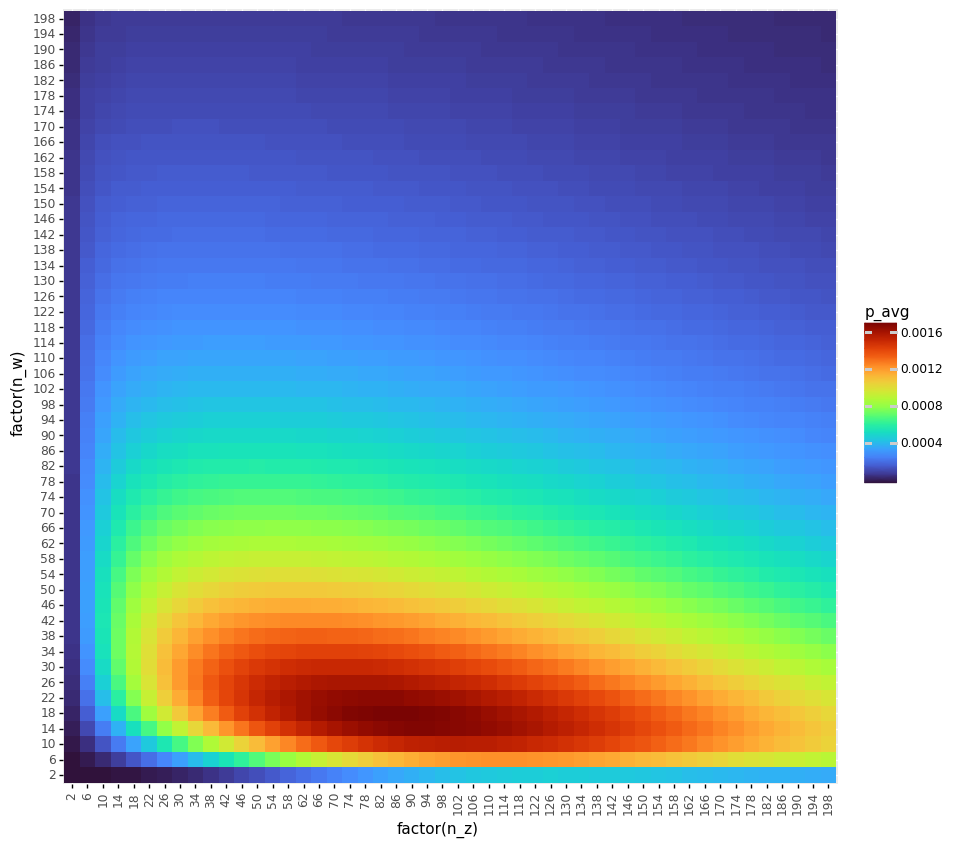

<ggplot: (8746258912521)>

In [35]:
from plotnine import *
p = ggplot(aes(x='factor(n_z)', y='factor(n_w)', fill='p_avg'), df_1c1m)
p + geom_tile() + coord_equal() + scale_fill_cmap('turbo') + theme(figure_size=(10, 7.5), axis_text_x=element_text(angle=90))

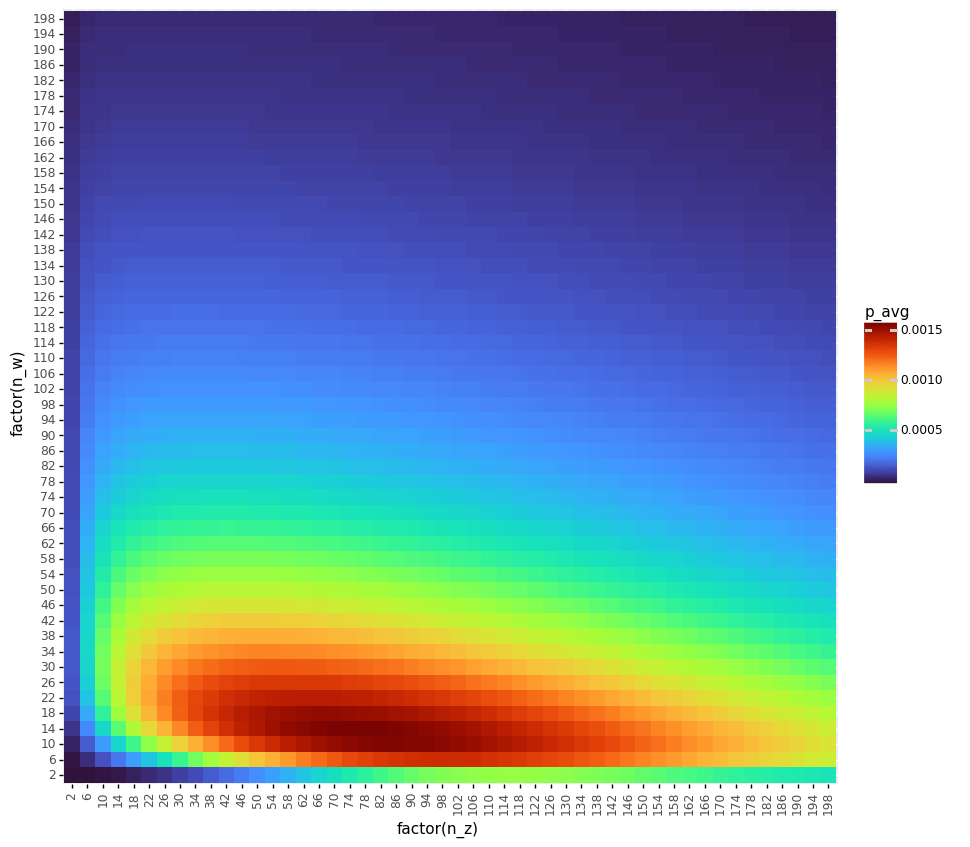

<ggplot: (8746228933749)>

In [36]:
p = ggplot(aes(x='factor(n_z)', y='factor(n_w)', fill='p_avg'), df_2c1m)
p + geom_tile() + coord_equal() + scale_fill_cmap('turbo') + theme(figure_size=(10, 7.5), axis_text_x=element_text(angle=90))

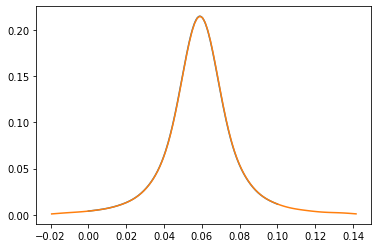

In [234]:
# Double check we get the same flux curves
coil_params['n_z'] = 55
coil_params['n_w'] = 145

simulation_models = optimize.evolve_simulation_set(
    unified_model_factory=unified_model_factory,
    input_excitations=[acc_input],
    curve_model=curve_model,
    coil_model_params=coil_params)

um = simulation_models[0]


xs = np.linspace(0, 0.1, 1000)
phi_from_model = [um.electrical_model.flux_model.get(x) for x in xs]
plt.plot(xs, phi_from_model)

xs, phi = curve_model.predict_curve([[coil_params['n_z'], coil_params['n_w']]])
plt.plot(xs + 0.059, phi.flatten())

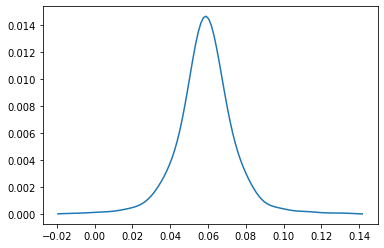

In [188]:
xs, phi = curve_model.predict_curve([[5, 95]])
plt.plot(xs + 0.059, phi.flatten())

# xs, phi = curve_model.predict_curve([[15, 65]])
# plt.plot(xs, phi.flatten())